In [1]:
import importlib
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
font = {#'family' : 'normal',
    #'weight' : 'normal',
    'size'   : 16}
matplotlib.rc('font', **font)

H = importlib.import_module("projects.al-benchmark.core.helper_functions")
full_plot = H.full_plot

# Splice

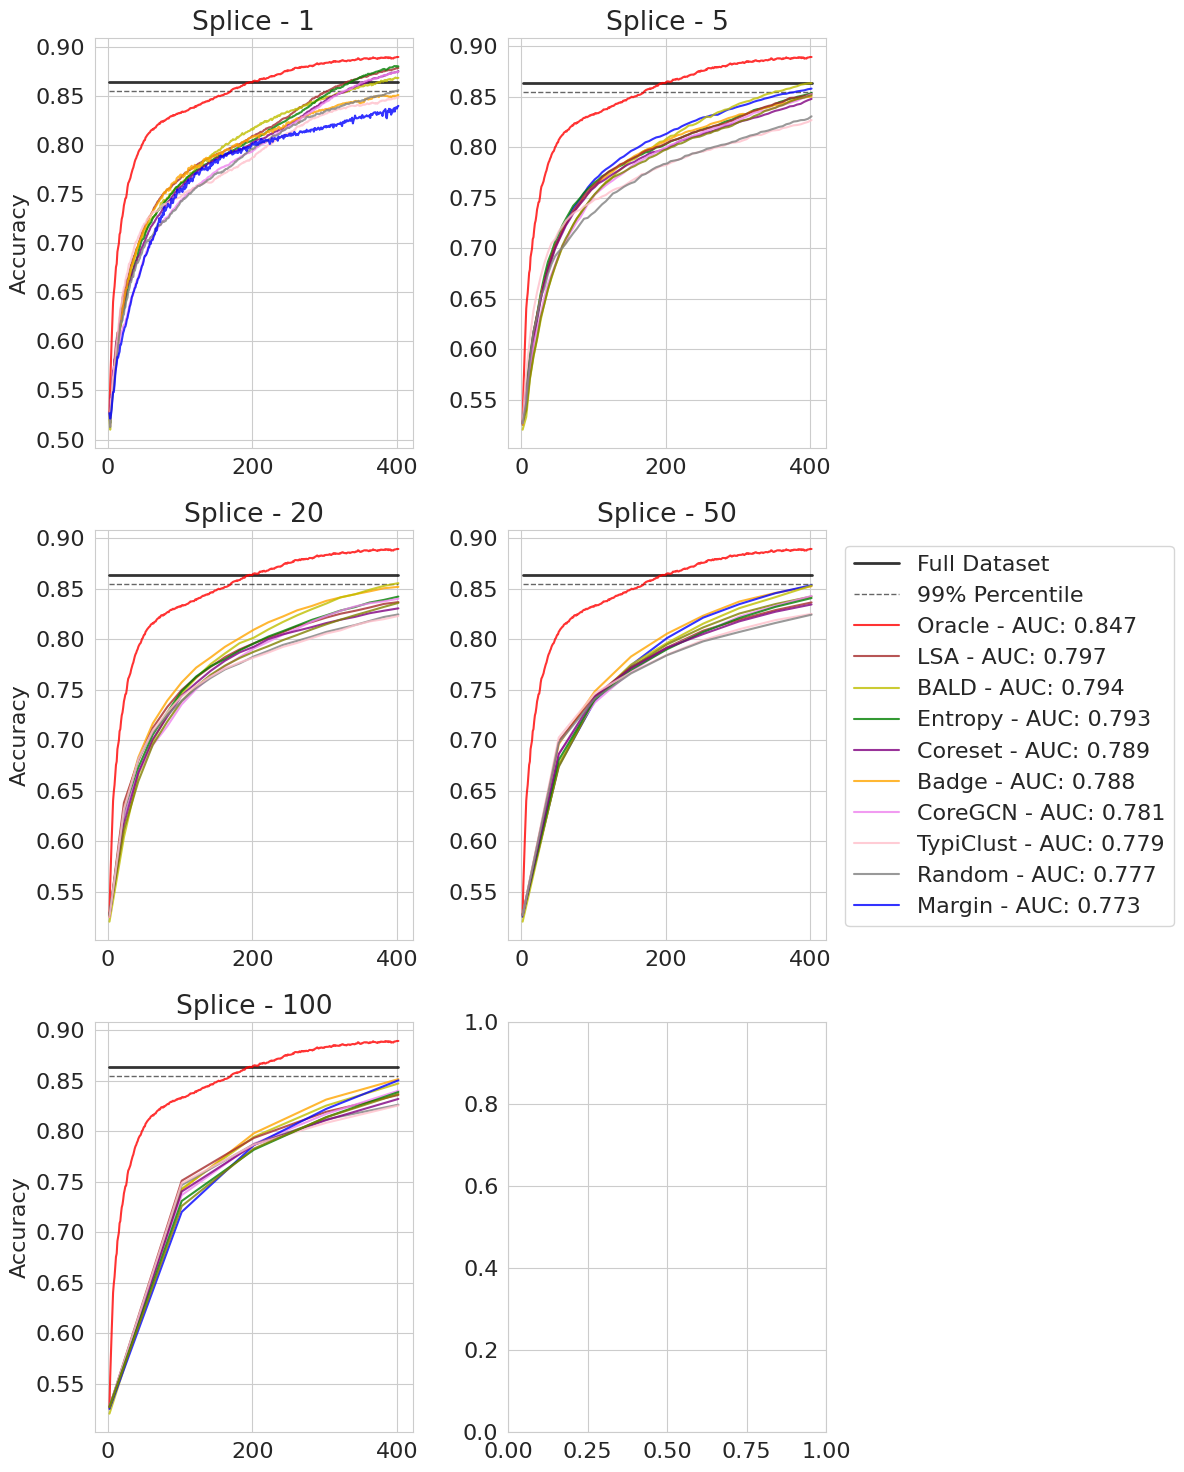

In [2]:
full_plot("Splice", query_size=None, radjust=0.7)
# plt.savefig("doc/img/test.pdf")
plt.show()

# DNA

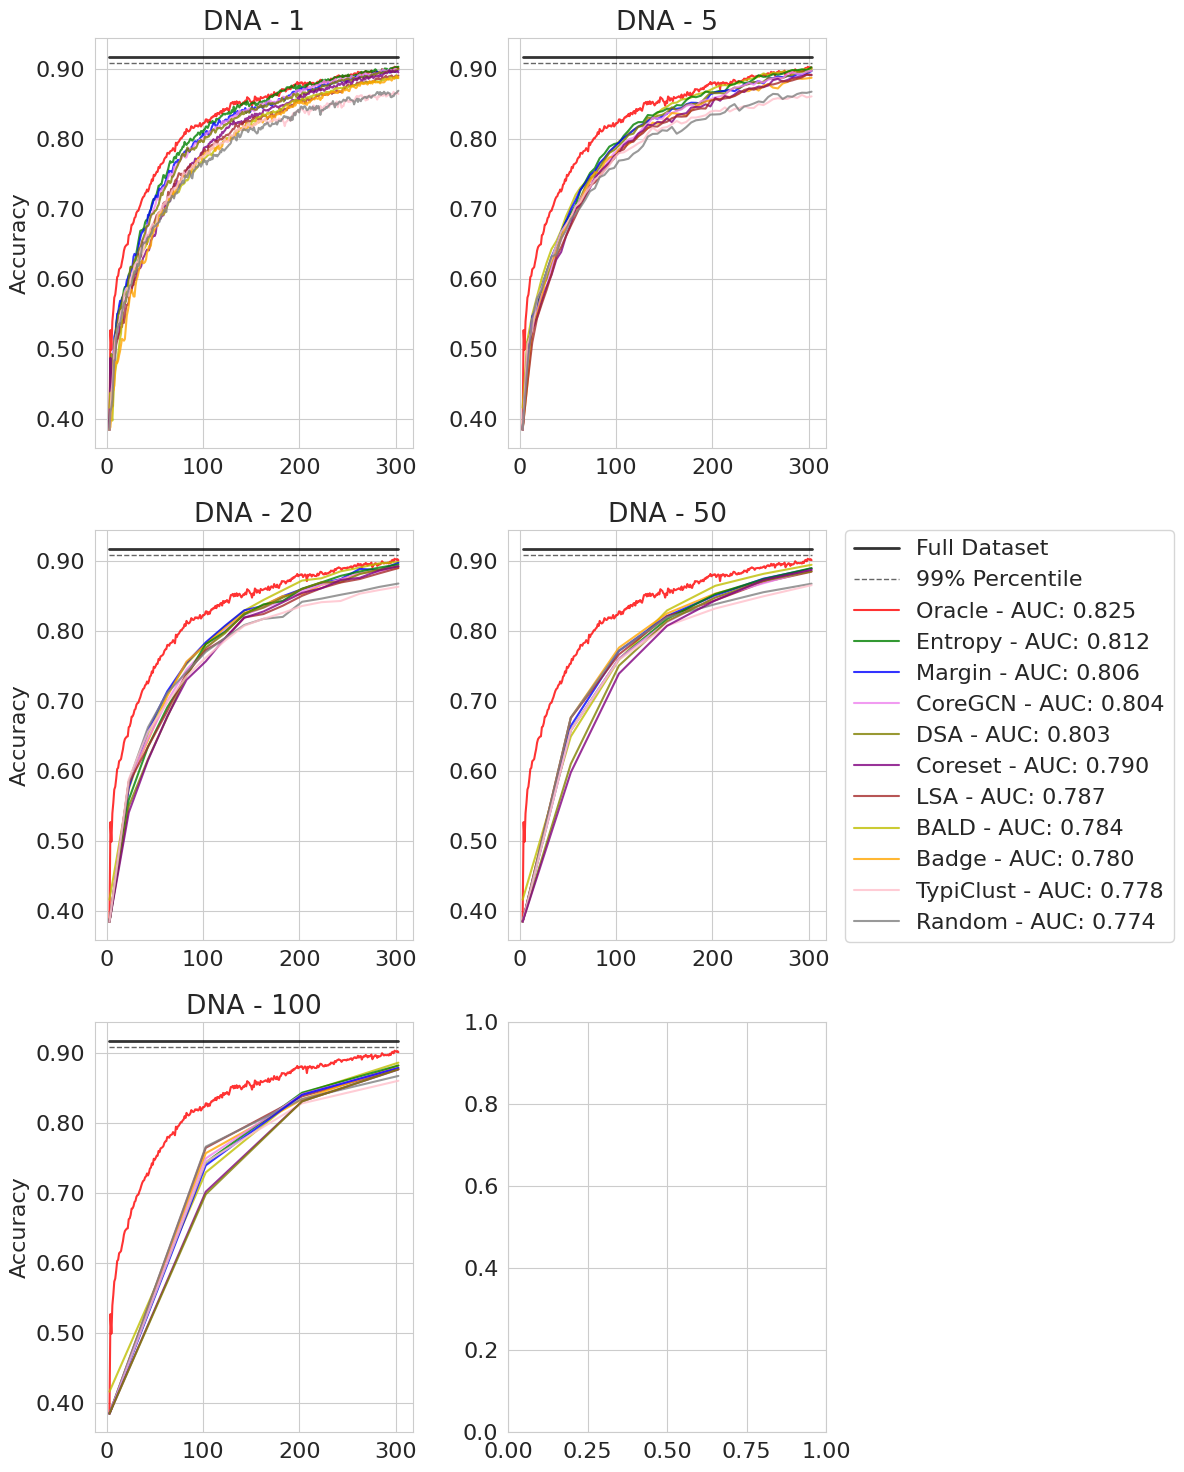

In [4]:
full_plot("DNA", query_size=None, radjust=0.7)
# plt.savefig("doc/img/eval_dna.pdf")
plt.show()

# USPS

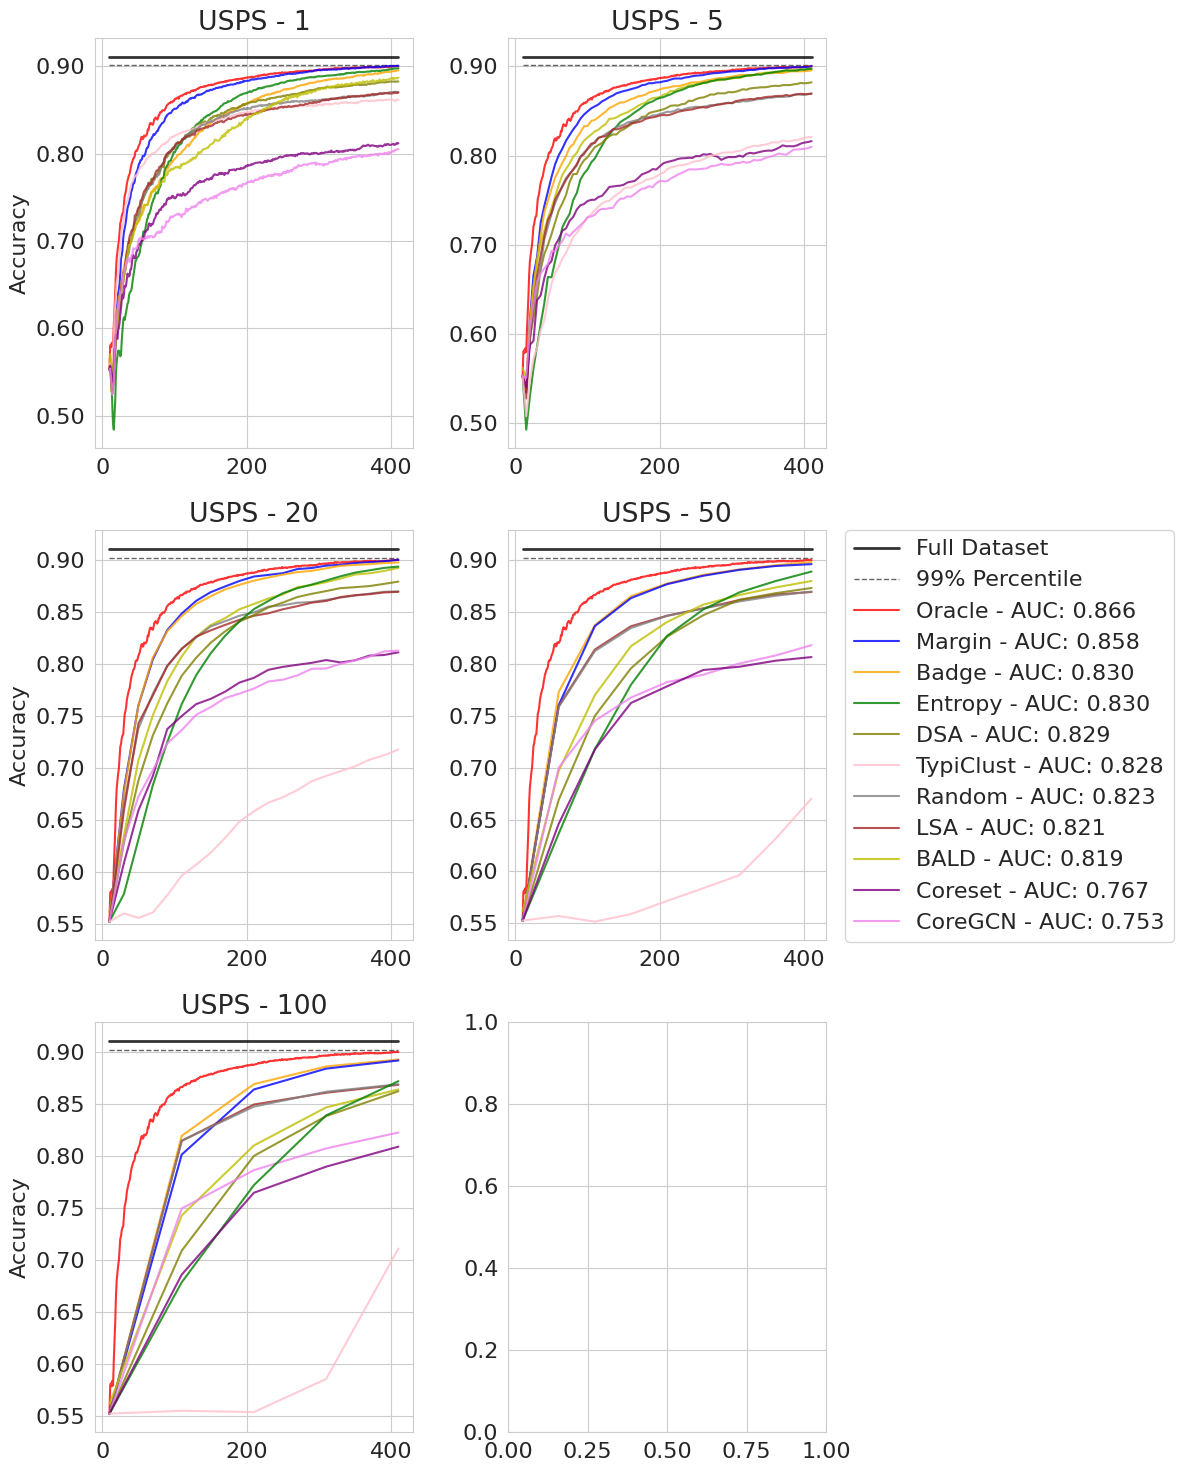

In [5]:
full_plot("USPS", query_size=None, radjust=0.7)
# plt.savefig("doc/img/eval_usps.pdf")
plt.show()

# Cifar10 Encoded

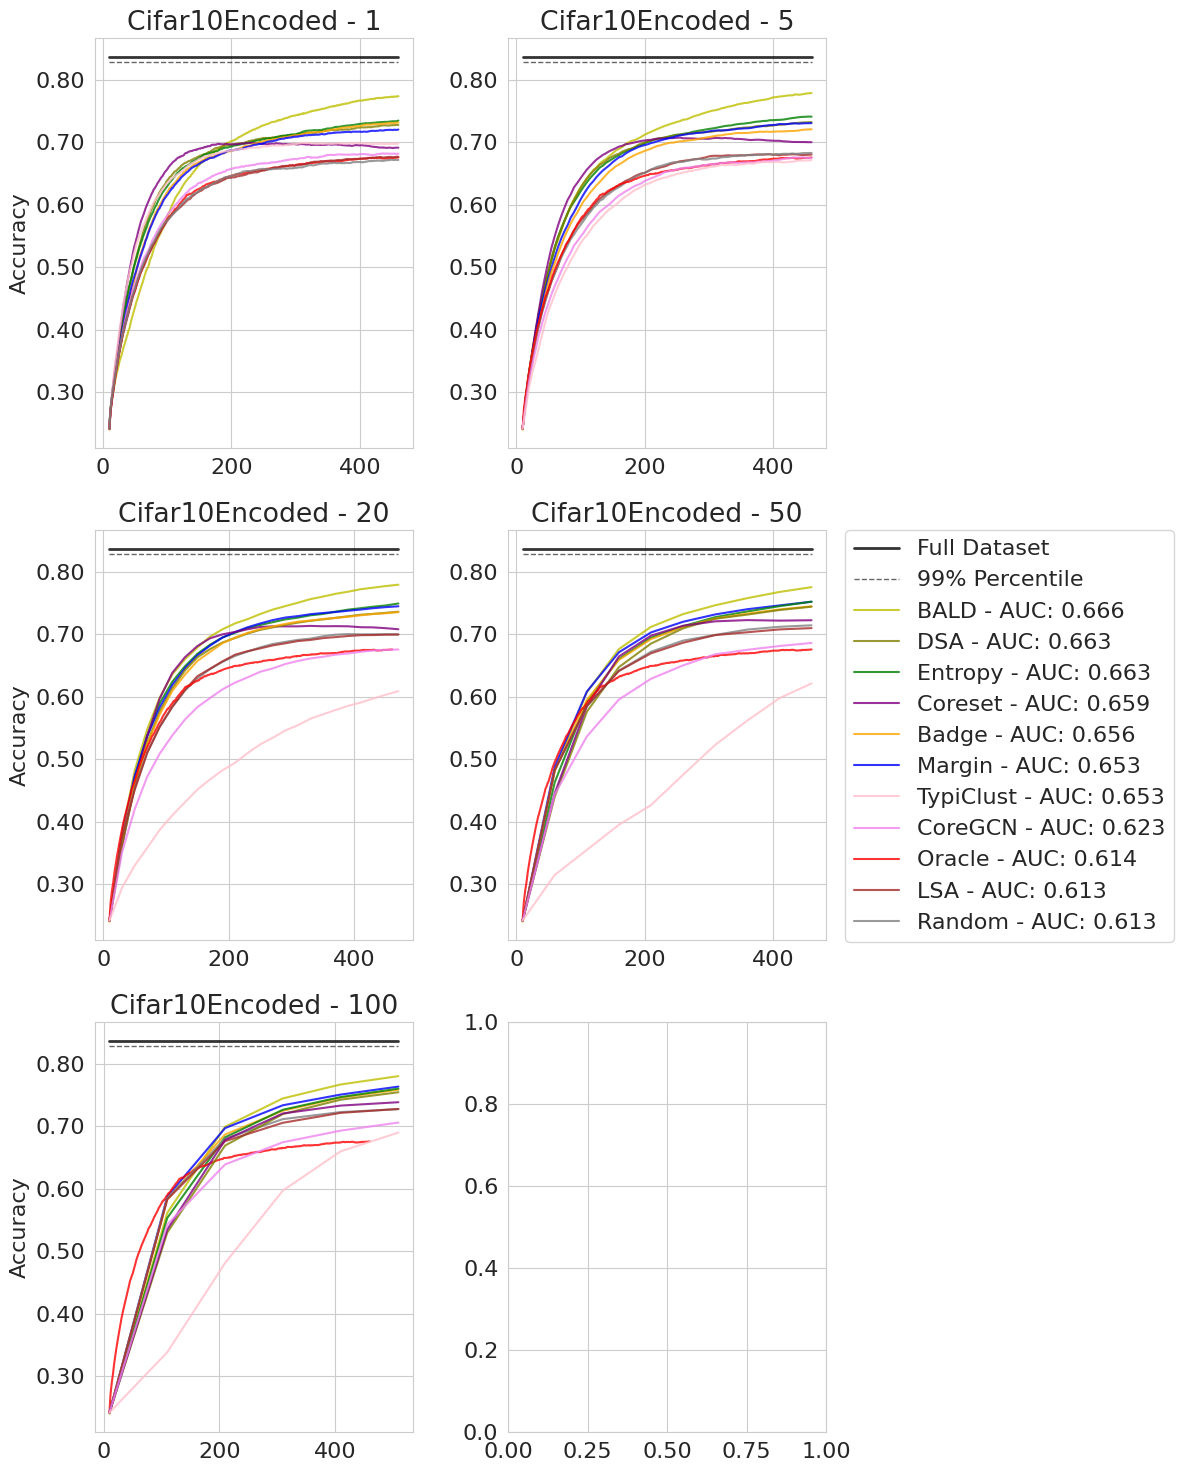

In [6]:
# Oracle, CoreGCN
full_plot("Cifar10Encoded", query_size=None, radjust=0.7)
# plt.savefig("doc/img/eval_cifar10_enc.pdf")
plt.show()

# FashionMnist Encoded

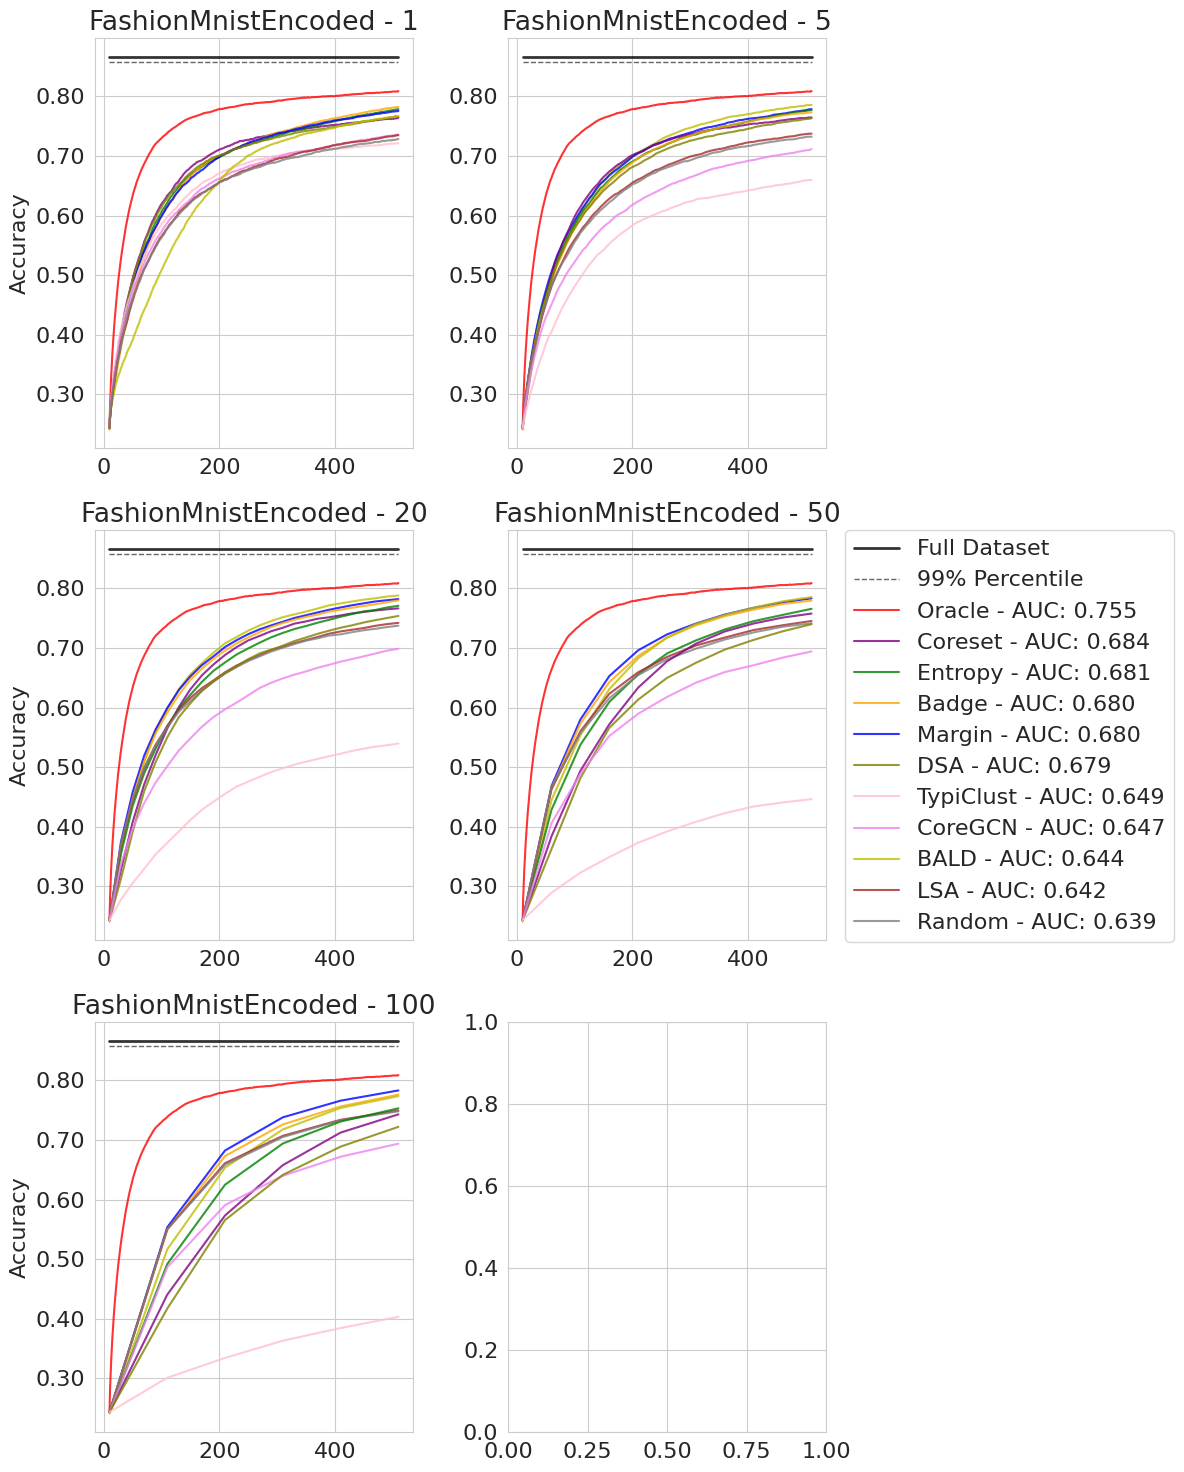

In [7]:
# Oracle, CoreGCN
full_plot("FashionMnistEncoded", query_size=None, radjust=0.7)
# plt.savefig("doc/img/eval_fmnist_enc.pdf")
plt.show()

# TopV2

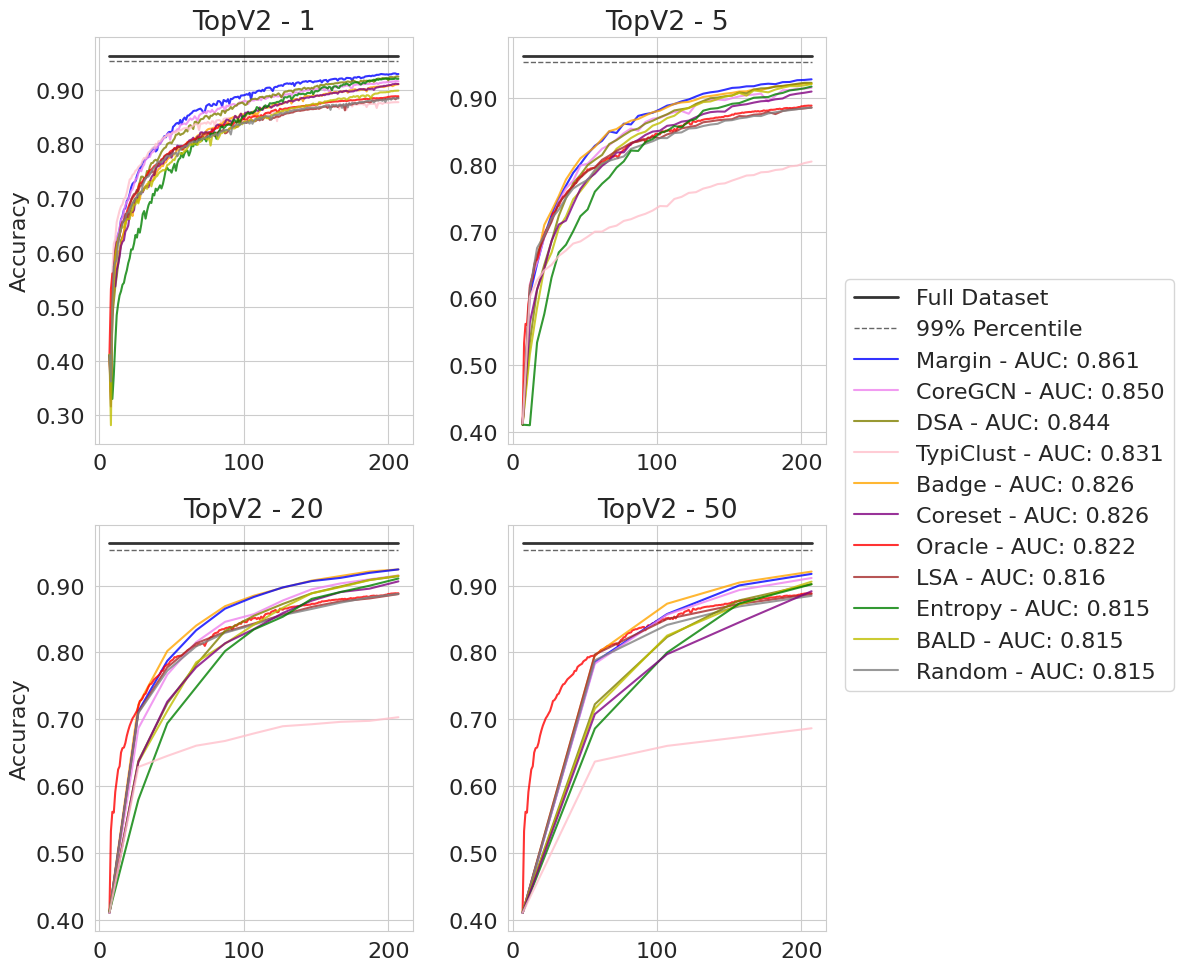

In [8]:
# Oracle, CoreGCN
full_plot("TopV2", query_size=None, radjust=0.7)
# plt.savefig("doc/img/eval_topv2.pdf")
plt.show()

# News

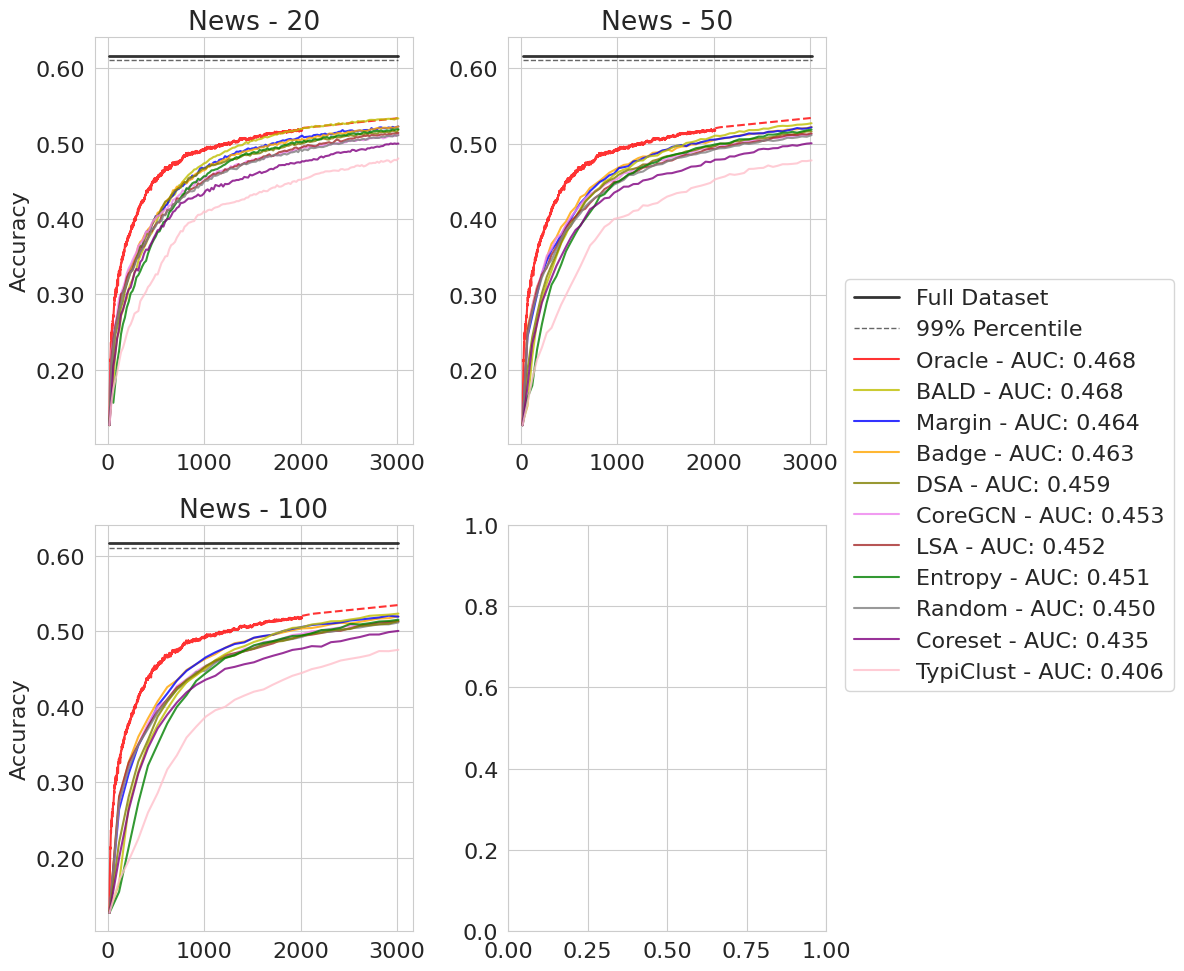

In [9]:
# Oracle, CoreGCN
full_plot("News", query_size=None, radjust=0.7)
# plt.savefig("doc/img/eval_news.pdf")
plt.show()

# Splice Embedded

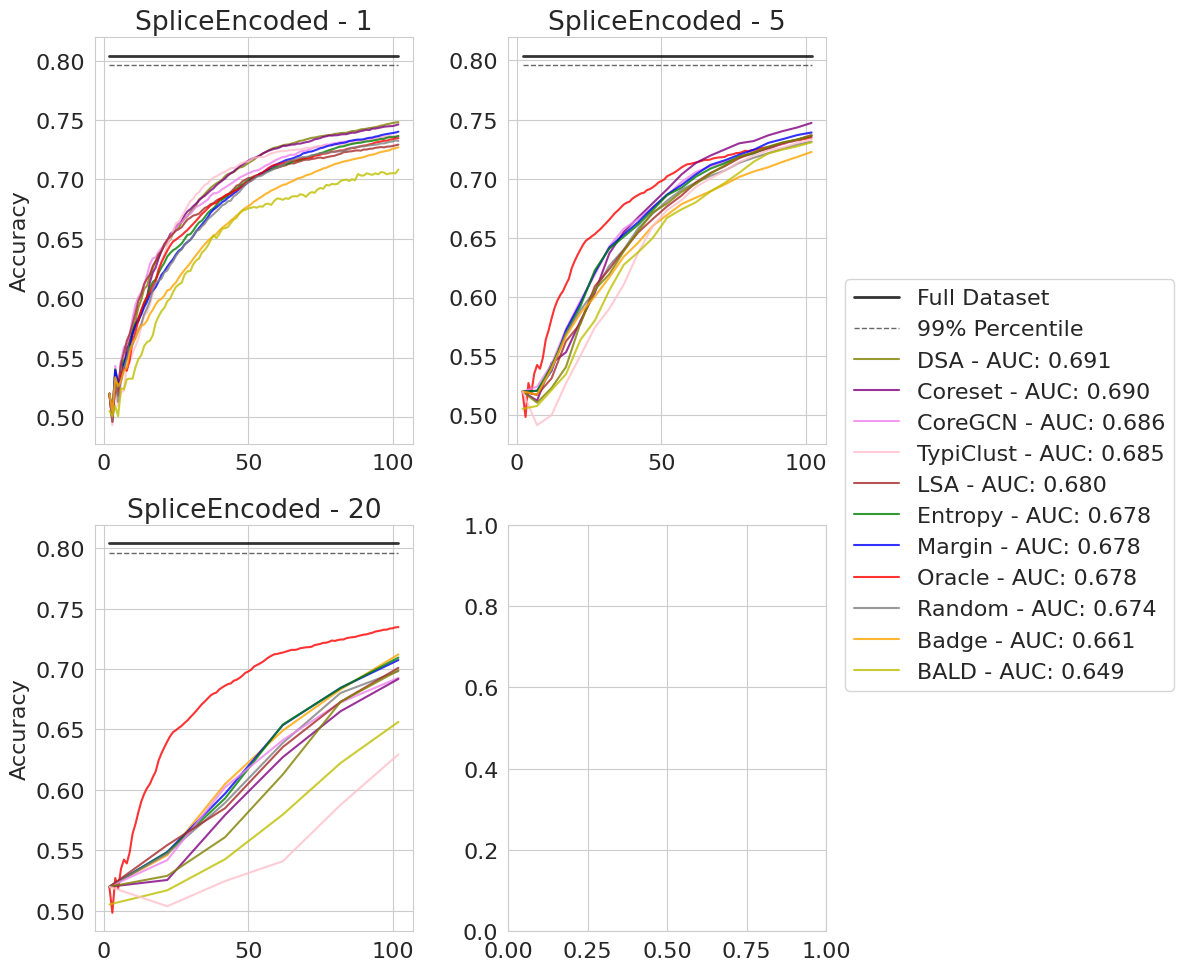

In [19]:
# Oracle, CoreGCN
full_plot("SpliceEncoded", query_size=None, radjust=0.7)
# plt.savefig("doc/img/eval_splice_enc.pdf")
plt.show()

# DNA Embedded

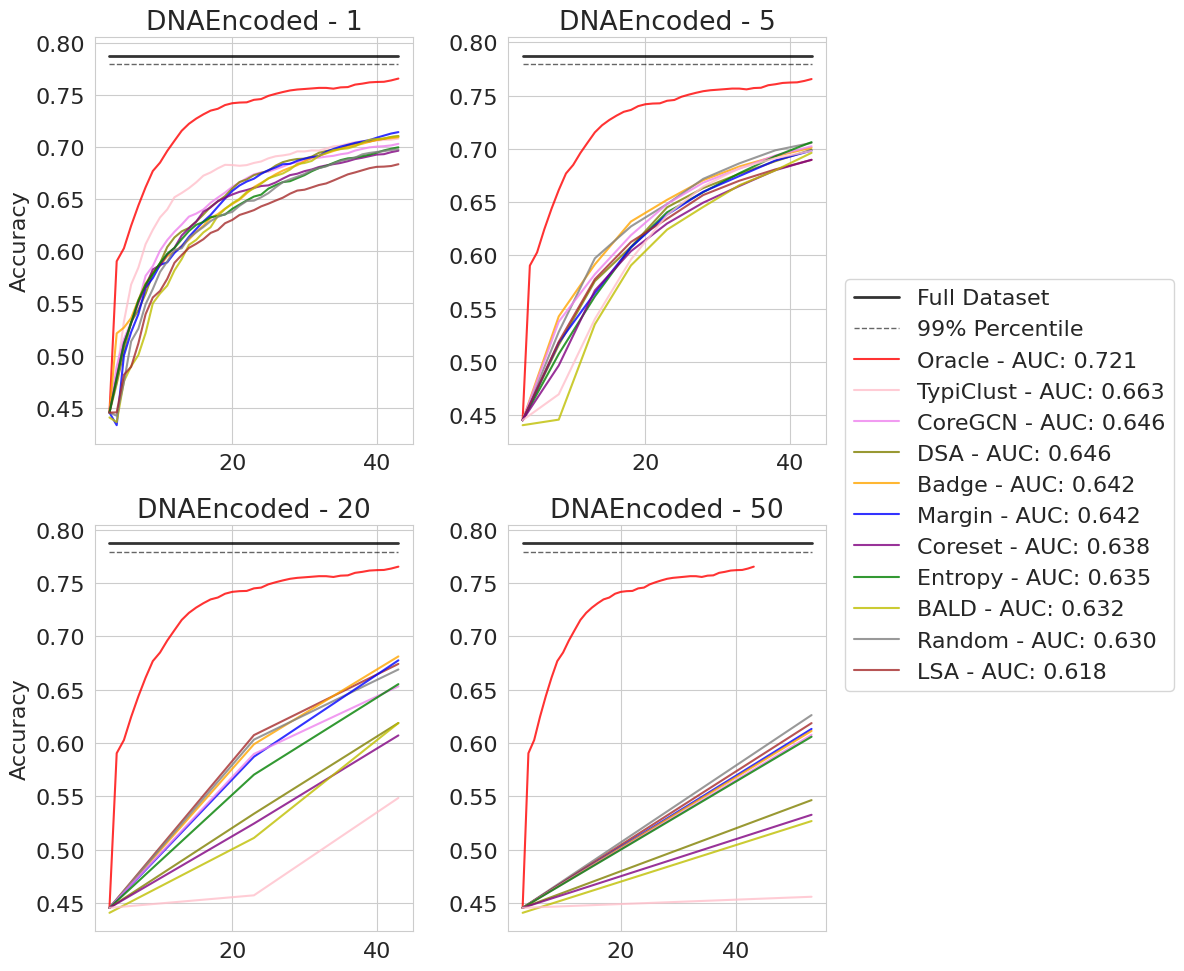

In [11]:
full_plot("DNAEncoded", query_size=None, radjust=0.7)
# plt.savefig("doc/img/eval_dna_enc.pdf")
plt.show()


# USPS Embedded

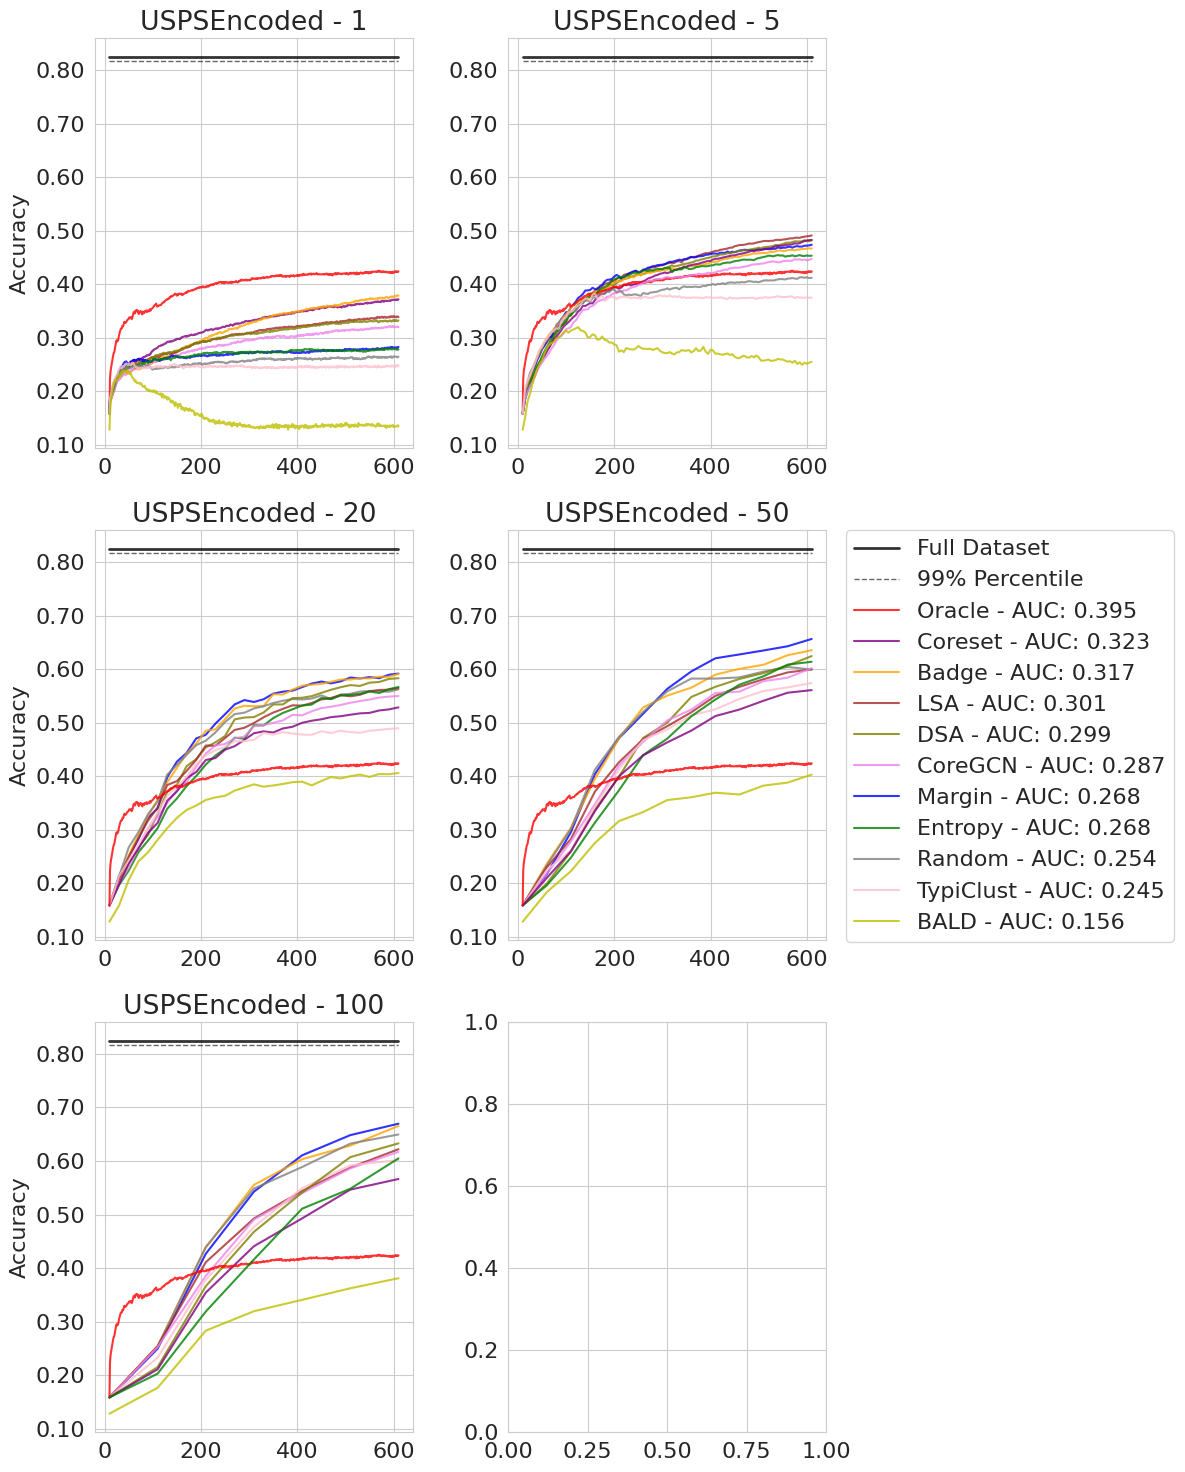

In [12]:
full_plot("USPSEncoded", query_size=None, radjust=0.7)
# plt.savefig("doc/img/eval_usps_enc.pdf")
plt.show()

# Cifar10

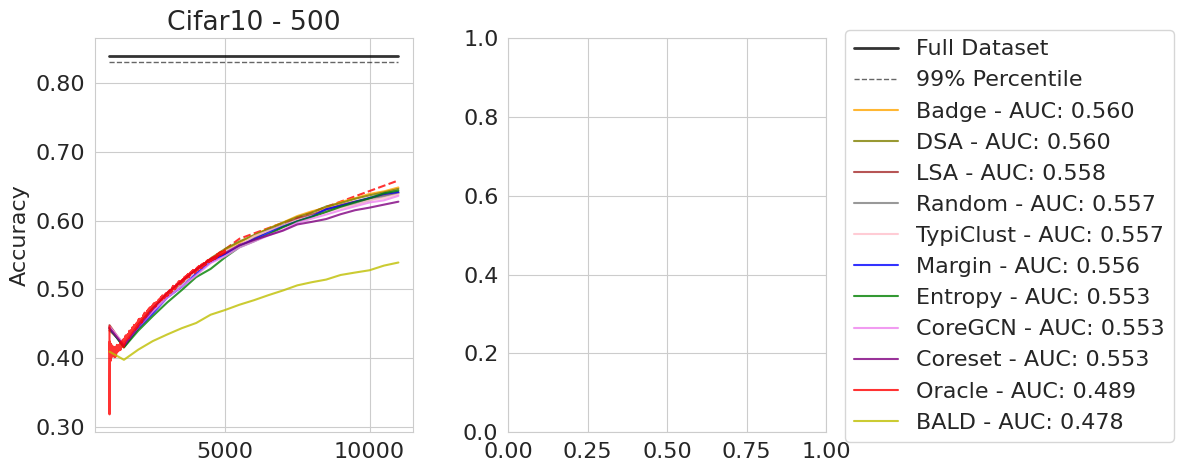

In [21]:
# Oracle, CoreGCN
full_plot("Cifar10", query_size=None, radjust=0.7)
# plt.savefig("doc/img/eval_cifar10.pdf")
plt.show()

# FashionMnist

[Warning]: axis of agent MarginScore is different from others
MarginScore: [1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 8000, 8500, 9000]
Previous: [1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]
Ignoring...
[Warning]: axis of agent RandomAgent is different from others
RandomAgent: [1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 8000, 8500, 9000, 9500, 10000, 10500, 11000]
Previous: [1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]
Ignoring...


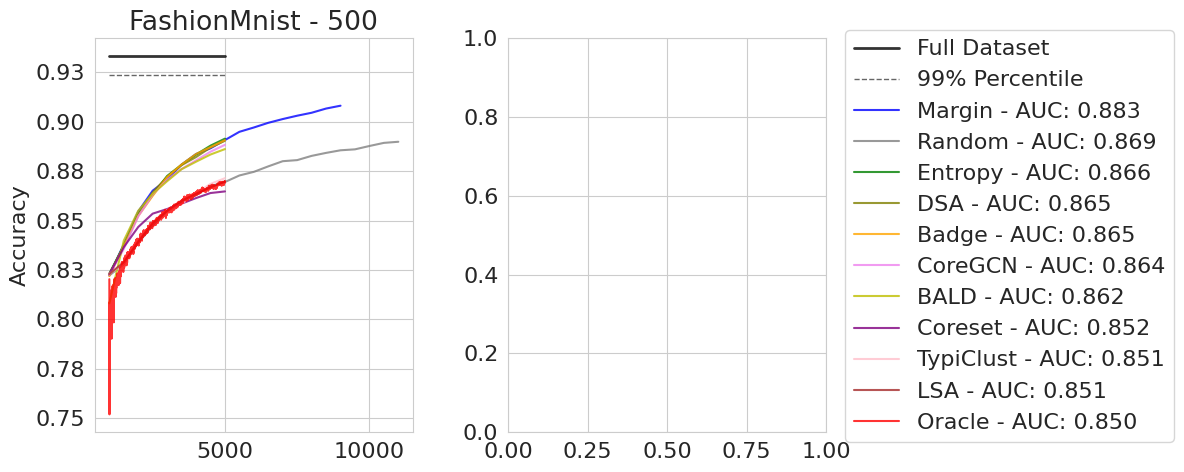

In [14]:
full_plot("FashionMnist", query_size=None, radjust=0.7, forecast_oracle=False)
# plt.savefig("doc/img/eval_fmnist.pdf")
plt.show()

# ThreeClust

<Figure size 960x720 with 0 Axes>

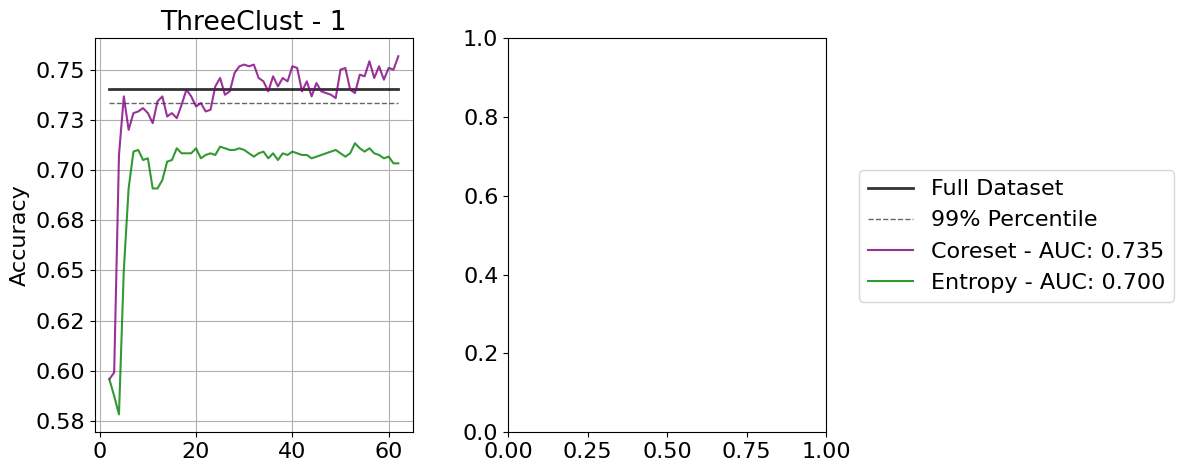

In [3]:
plt.figure(dpi=150)

full_plot("ThreeClust", query_size=None, radjust=0.7, forecast_oracle=False)
plt.show()

# DivergingSin

<Figure size 960x720 with 0 Axes>

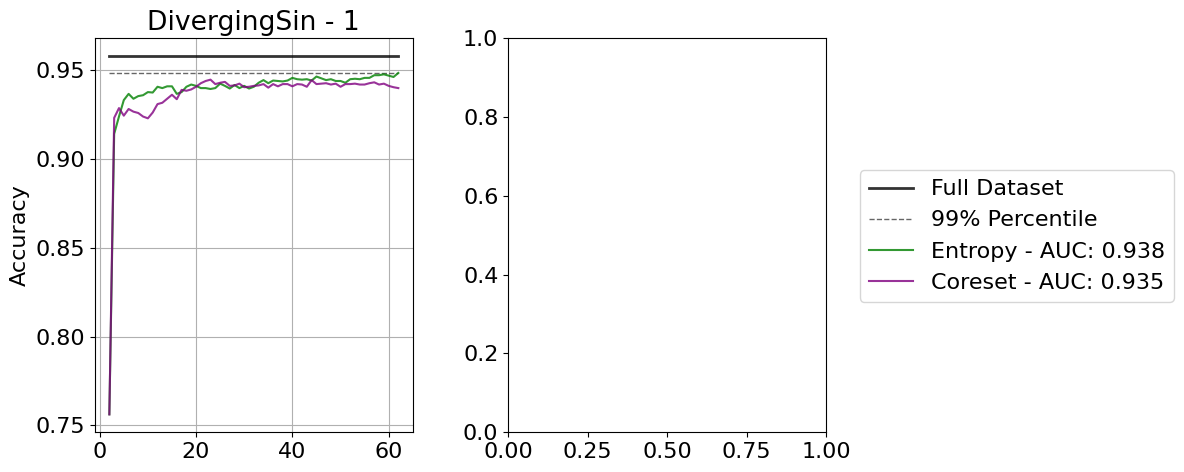

In [5]:
plt.figure(dpi=150)

full_plot("DivergingSin", query_size=None, radjust=0.7, forecast_oracle=False)
plt.show()

# Comparison Batch AL vs. Single-Sample Al

In [ ]:
fig, axes = plt.subplots(1, 2, dpi=150, figsize=(12,5))
show_auc = True
agent = "Coreset_Greedy"
plot_single(axes[0], "Splice", 1, "Oracle", label="Oracle", color="red", show_auc=show_auc)
plot_single(axes[0], "Splice", 1, agent, label=f"Coreset (1)", color="green", show_auc=show_auc)
plot_single(axes[0], "Splice", 20, agent, label=f"Coreset (20)", color="orange", show_auc=show_auc)
plot_single(axes[0], "Splice", 50, agent, label=f"Coreset (50)", color="y", show_auc=show_auc)
axes[0].set_title('Splice - Coreset')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('# labeled datapoints')
plt.grid(visible=True)
axes[0].legend(fontsize='x-small')
axes[0].yaxis.set_major_formatter(FormatStrFormatter('%0.2f'))

agent = "Badge"
plot_single(axes[1], "Splice", 1, "Oracle", label="Oracle", color="red", show_auc=show_auc)
plot_single(axes[1], "Splice", 1, agent, label=f"Badge (1)", color="green", show_auc=show_auc)
plot_single(axes[1], "Splice", 20, agent, label=f"Badge (20)", color="orange", show_auc=show_auc)
plot_single(axes[1], "Splice", 50, agent, label=f"Badge (50)", color="y", show_auc=show_auc)
axes[1].set_title('Splice - Badge')
axes[1].set_ylabel('Accuracy')
axes[1].set_xlabel('# labeled datapoints')
plt.grid(visible=True)
axes[1].legend(fontsize='x-small')
axes[1].yaxis.set_major_formatter(FormatStrFormatter('%0.2f'))

plt.tight_layout()
# plt.savefig("doc/img/ablation_batch_single.jpg")
plt.show()

In [ ]:
fig, axes = plt.subplots(2, 2, dpi=150, figsize=(12,10))
show_auc = False
qs = 1
create_plot_for_query_size(axes[0, 0], "USPS", qs, "Accuracy", f"USPS - {qs}", 
                           smoothing_weight=0.0, show_auc=show_auc, forecast_oracle=False)
axes[0, 0].set_xlabel('# labeled datapoints')
plt.grid(visible=True)
# axes[0, 0].legend(fontsize='x-small')
axes[0, 0].yaxis.set_major_formatter(FormatStrFormatter('%0.2f'))

axes[0, 0].legend(loc=7, bbox_to_anchor=(-0.3, 0.5), fontsize='x-small')

qs = 20
create_plot_for_query_size(axes[0, 1], "USPS", qs, "Accuracy", f"USPS - {qs}",
                           smoothing_weight=0.0, show_auc=show_auc, forecast_oracle=False)
axes[0, 1].set_xlabel('# labeled datapoints')
plt.grid(visible=True)
# axes[0, 1].legend(fontsize='x-small')
axes[0, 1].yaxis.set_major_formatter(FormatStrFormatter('%0.2f'))

qs = 1
create_plot_for_query_size(axes[1, 0], "FashionMnistEncoded", qs, "Accuracy", f"FashionMnist(Encoded) - {qs}",
                           smoothing_weight=0.0, show_auc=show_auc, forecast_oracle=False)
axes[1, 0].set_xlabel('# labeled datapoints')
plt.grid(visible=True)
# axes[0, 0].legend(fontsize='x-small')
axes[1, 0].yaxis.set_major_formatter(FormatStrFormatter('%0.2f'))
axes[1, 0].legend(loc=7, bbox_to_anchor=(-0.3, 0.5), fontsize='x-small')

qs = 20
create_plot_for_query_size(axes[1, 1], "FashionMnistEncoded", qs, "Accuracy", f"FashionMnist(Encoded) - {qs}",
                           smoothing_weight=0.0, show_auc=show_auc, forecast_oracle=False)
axes[1, 1].set_xlabel('# labeled datapoints')
plt.grid(visible=True)
# axes[0, 0].legend(fontsize='x-small')
axes[1, 1].yaxis.set_major_formatter(FormatStrFormatter('%0.2f'))

fig.subplots_adjust(right=0.8, hspace=0.2, wspace=0.3)

plt.tight_layout()
# plt.savefig("doc/img/main_body_result.jpg")
plt.show()